In [ ]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import gc

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, auc

from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns


In [45]:
df = pd.read_csv('banksim.csv')
print(df.shape)
df.head()

(594643, 10)


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [47]:
df.isna().any()

step           False
customer       False
age            False
gender         False
zipcodeOri     False
merchant       False
zipMerchant    False
category       False
amount         False
fraud          False
dtype: bool

In [48]:
column_change = [c for c in df.columns if c not in ['step', 'amount', 'fraud']]
column_change

['customer',
 'age',
 'gender',
 'zipcodeOri',
 'merchant',
 'zipMerchant',
 'category']

In [49]:
df[column_change] = df[column_change].replace("'", "", regex=True)

In [50]:
df.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


In [51]:
df.nunique()

step             180
customer        4112
age                8
gender             4
zipcodeOri         1
merchant          50
zipMerchant        1
category          15
amount         23767
fraud              2
dtype: int64

In [52]:
# ZipMerchant and zipcodeOri have only one unique value, therefore we can drop these columns
df = df.drop(['zipcodeOri','zipMerchant'], axis = 1)
df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0


In [53]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = df.loc[df.fraud == 1] 
df_non_fraud = df.loc[df.fraud == 0]

In [54]:
df_fraud.head()


,step,customer,age,gender,merchant,category,amount,fraud
88,0,C583110837,3,M,M480139044,es_health,44.26,1
89,0,C1332295774,3,M,M480139044,es_health,324.50,1
434,0,C1160421902,3,M,M857378720,es_hotelservices,176.32,1
435,0,C966214713,3,M,M857378720,es_hotelservices,337.41,1
553,0,C1450140987,4,F,M1198415165,es_wellnessandbeauty,220.11,1


In [55]:
df_non_fraud.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0


In [56]:
def edaplot(data: pd.DataFrame, col: str, title: str = None, hue: str = None, legend: bool = True):
    plt.figure(figsize=(17, 14))
    plt.title(title)
    ax = sns.countplot(
        data=data,
        x=col,
        palette='tab10',
        order=data[col].value_counts().index,
        hue=hue if hue else None
    )

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(data[col]), 2)}%",
                ha='center', va='bottom')

    if data[col].nunique() > 5:
        plt.xticks(rotation=45)

    if legend:
        ax.legend(title=hue)

    plt.show()


C:\Users\tejas\AppData\Local\Temp\ipykernel_3260\894592821.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


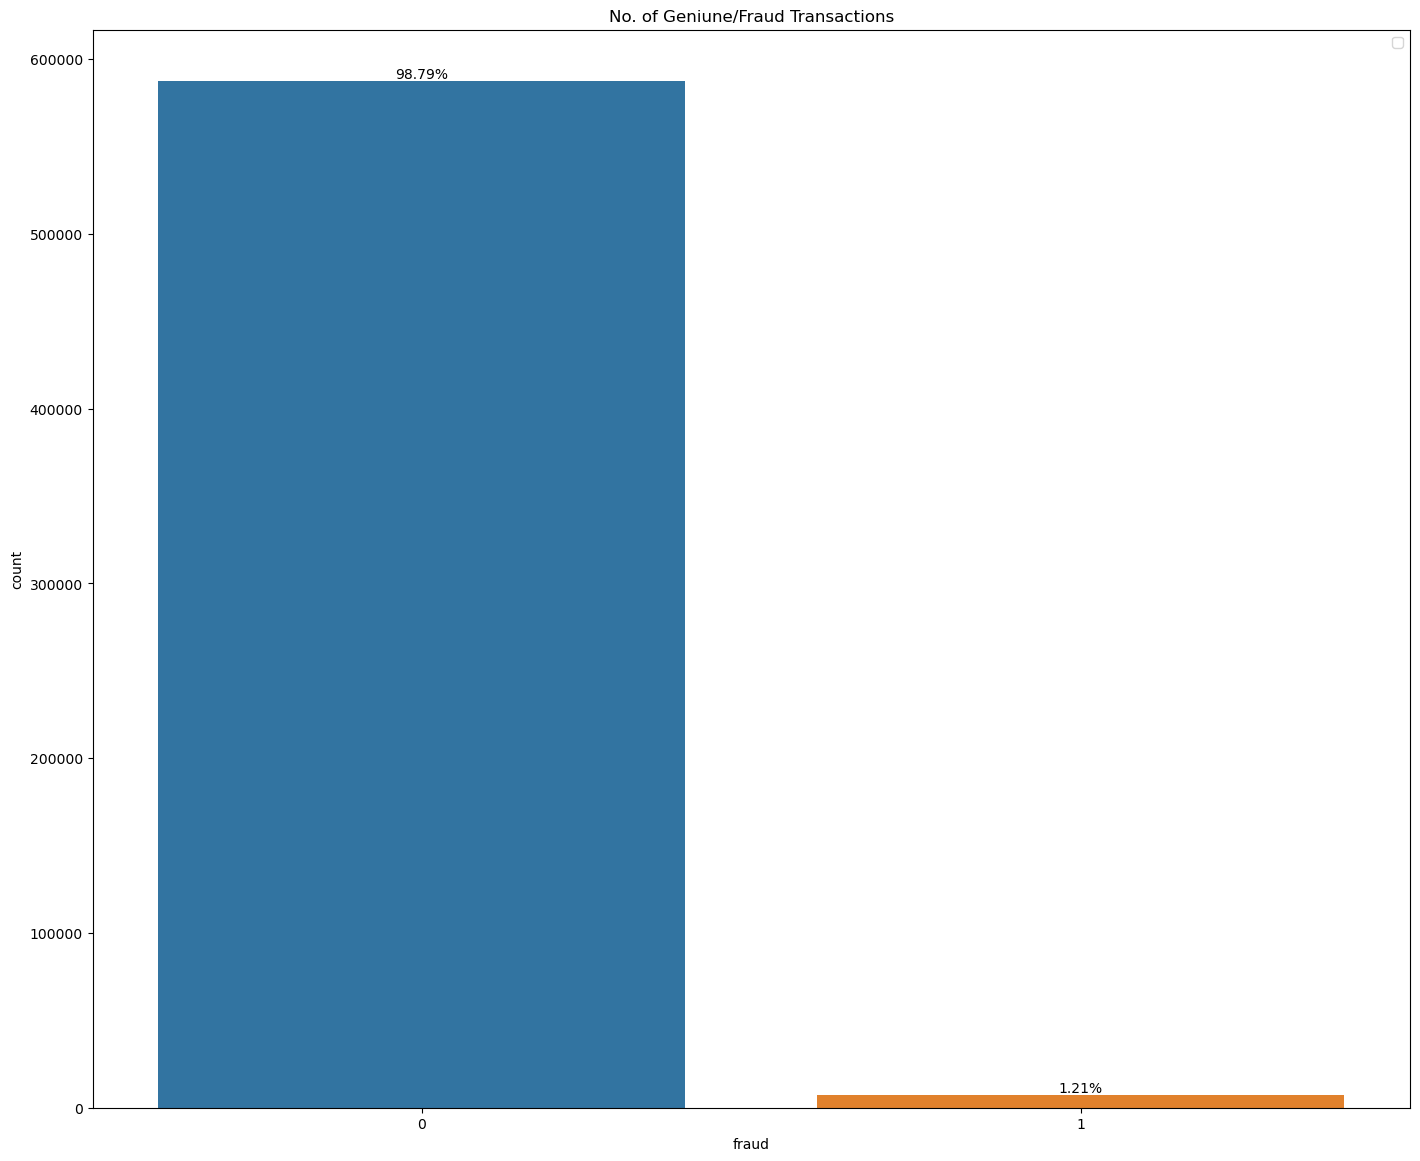

In [57]:
edaplot(df, 'fraud', title = 'No. of Geniune/Fraud Transactions', legend=True)

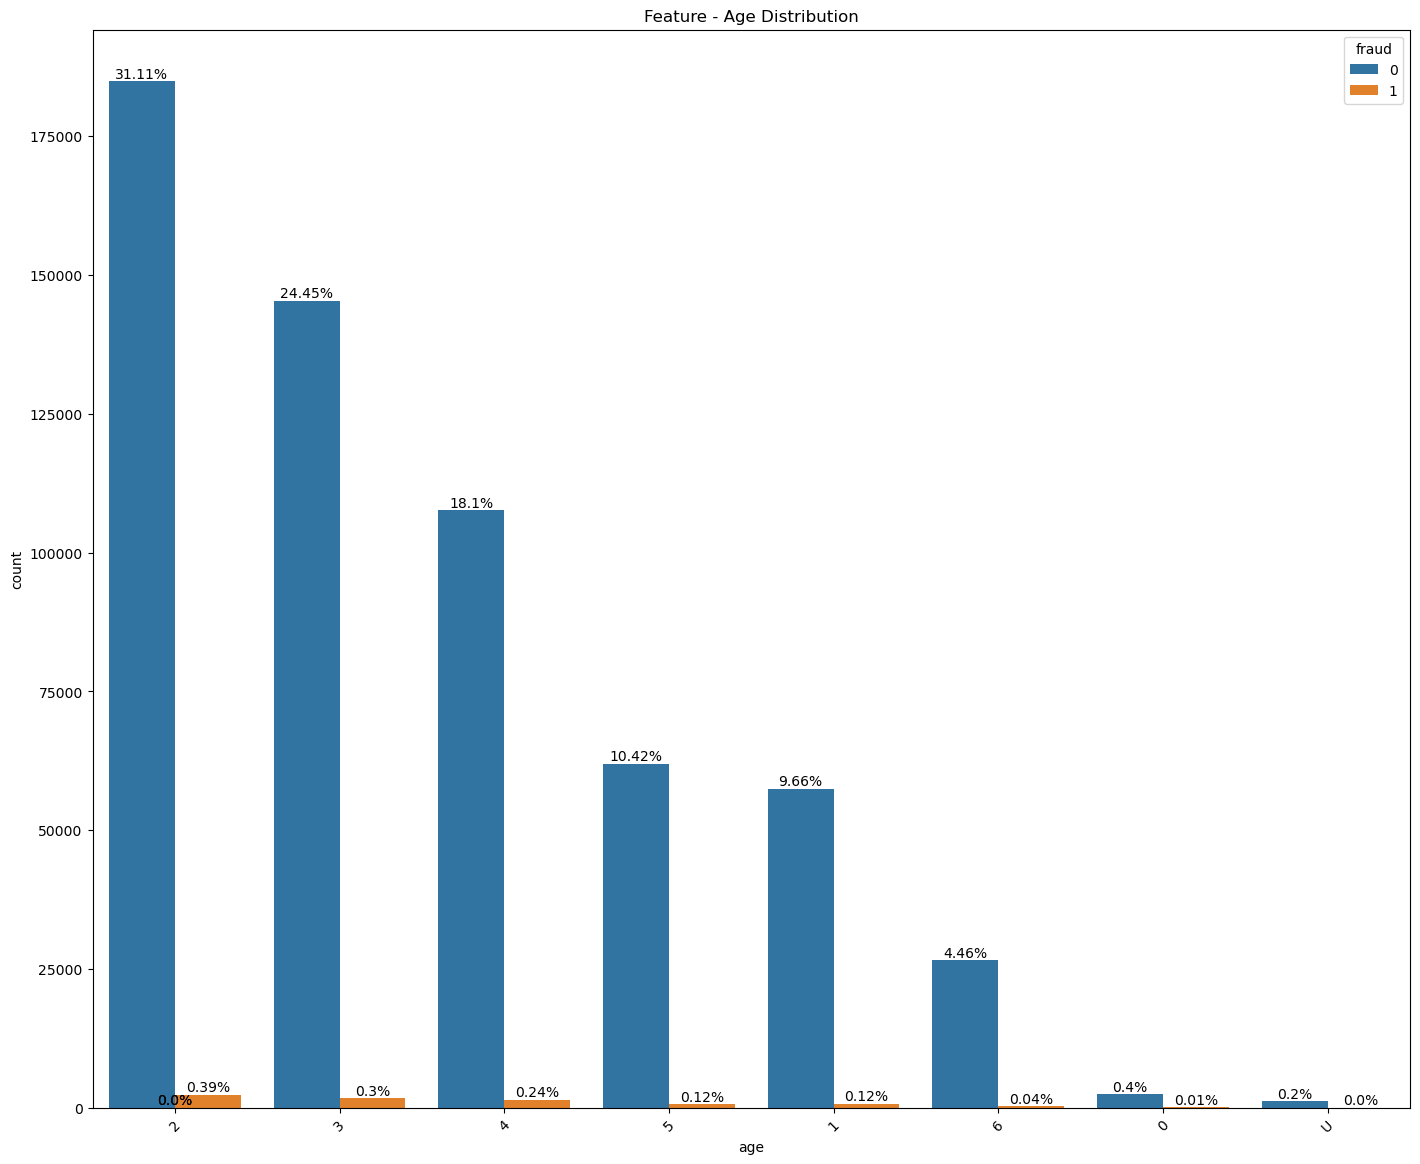

In [58]:
edaplot(df, 'age', title = 'Feature - Age Distribution', hue = 'fraud')

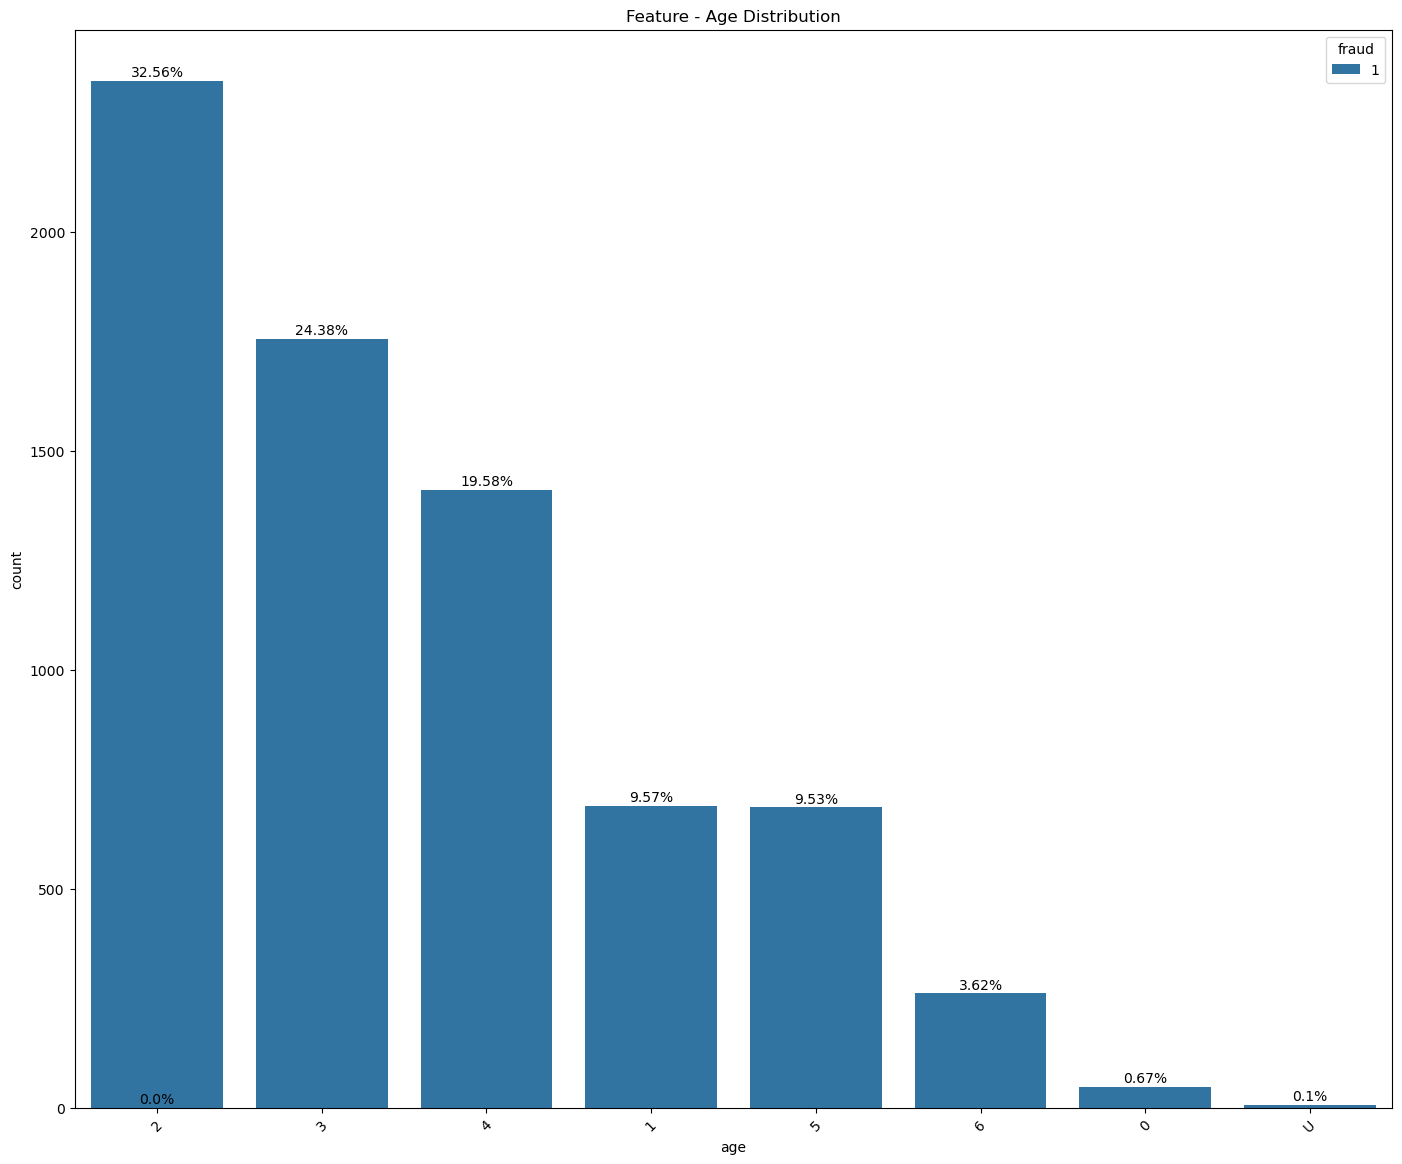

In [59]:
edaplot(df_fraud, 'age', title = 'Feature - Age Distribution', hue = 'fraud')

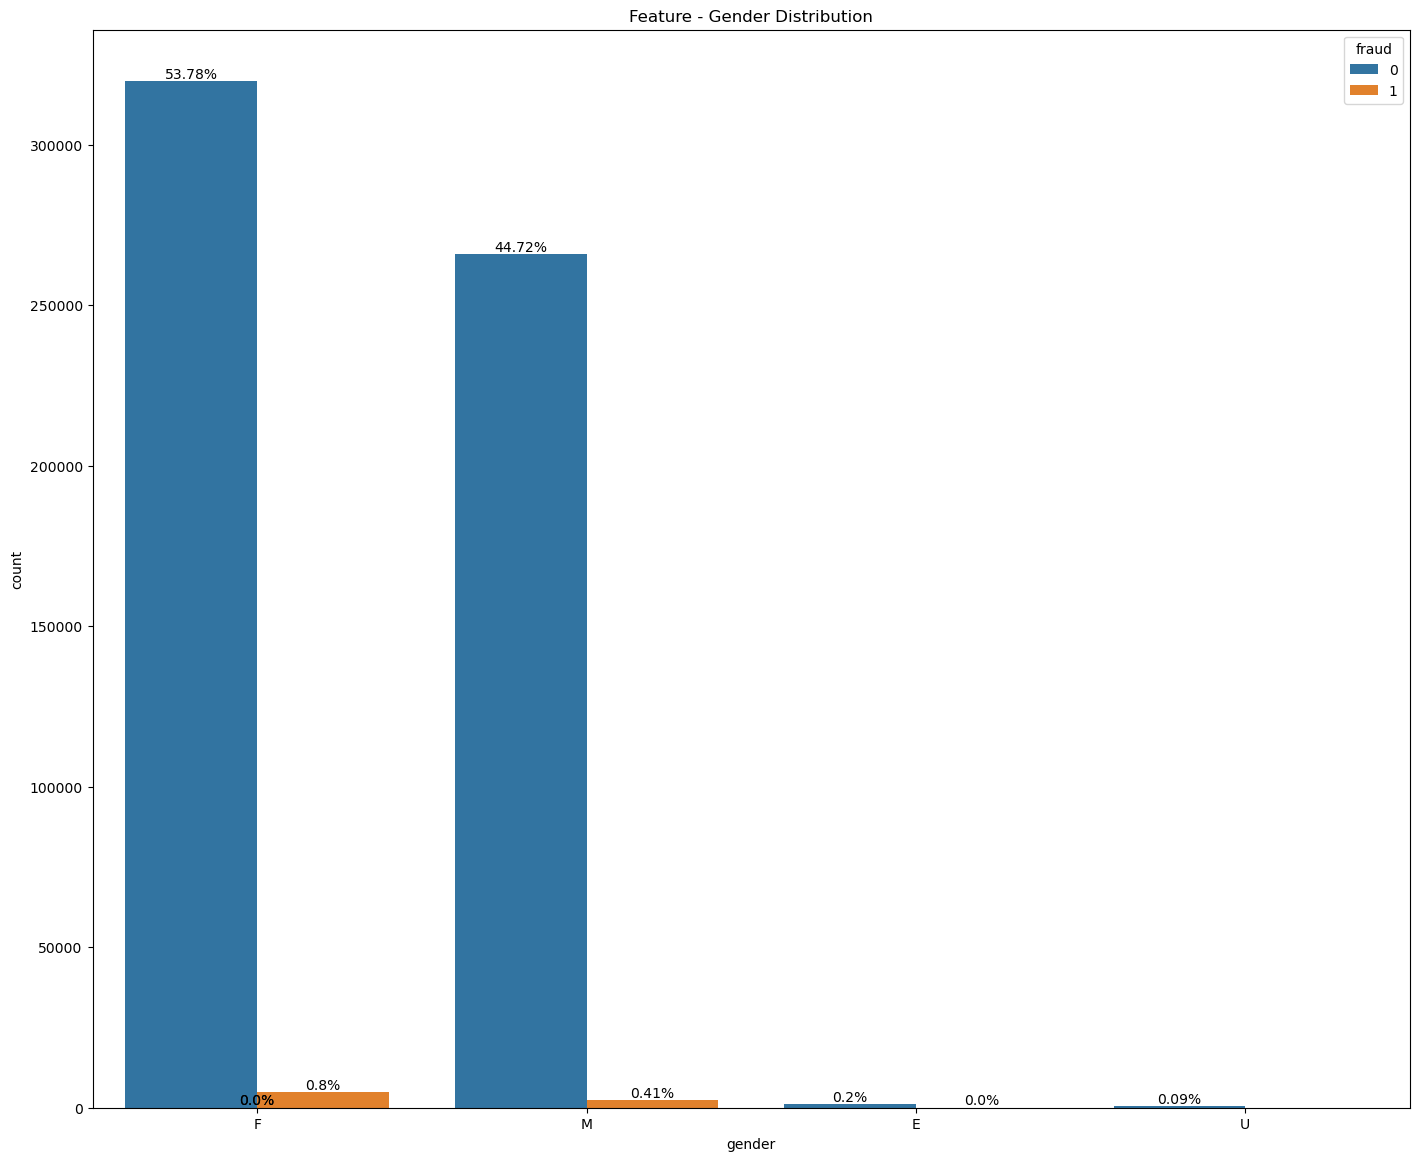

In [60]:
edaplot(df, 'gender', title = 'Feature - Gender Distribution', hue = 'fraud')

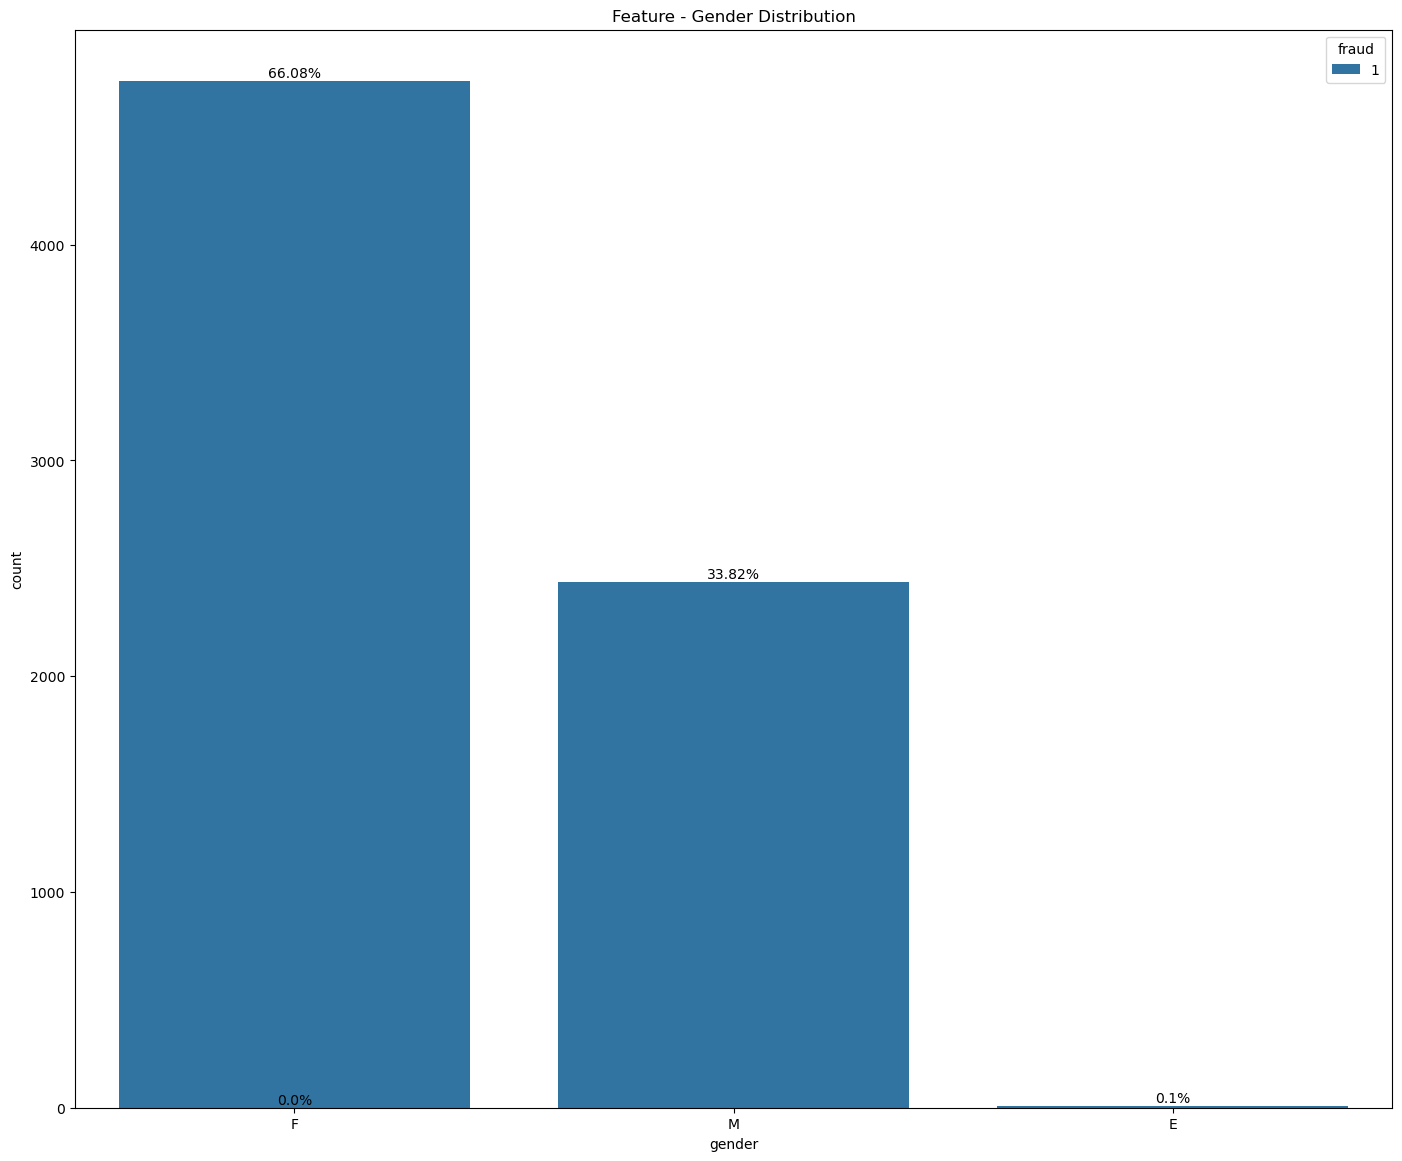

In [61]:
edaplot(df_fraud, 'gender', title = 'Feature - Gender Distribution', hue = 'fraud')

In [62]:
print(df['category'].unique())

['es_transportation' 'es_health' 'es_otherservices' 'es_food'
 'es_hotelservices' 'es_barsandrestaurants' 'es_tech' 'es_sportsandtoys'
 'es_wellnessandbeauty' 'es_hyper' 'es_fashion' 'es_home' 'es_contents'
 'es_travel' 'es_leisure']


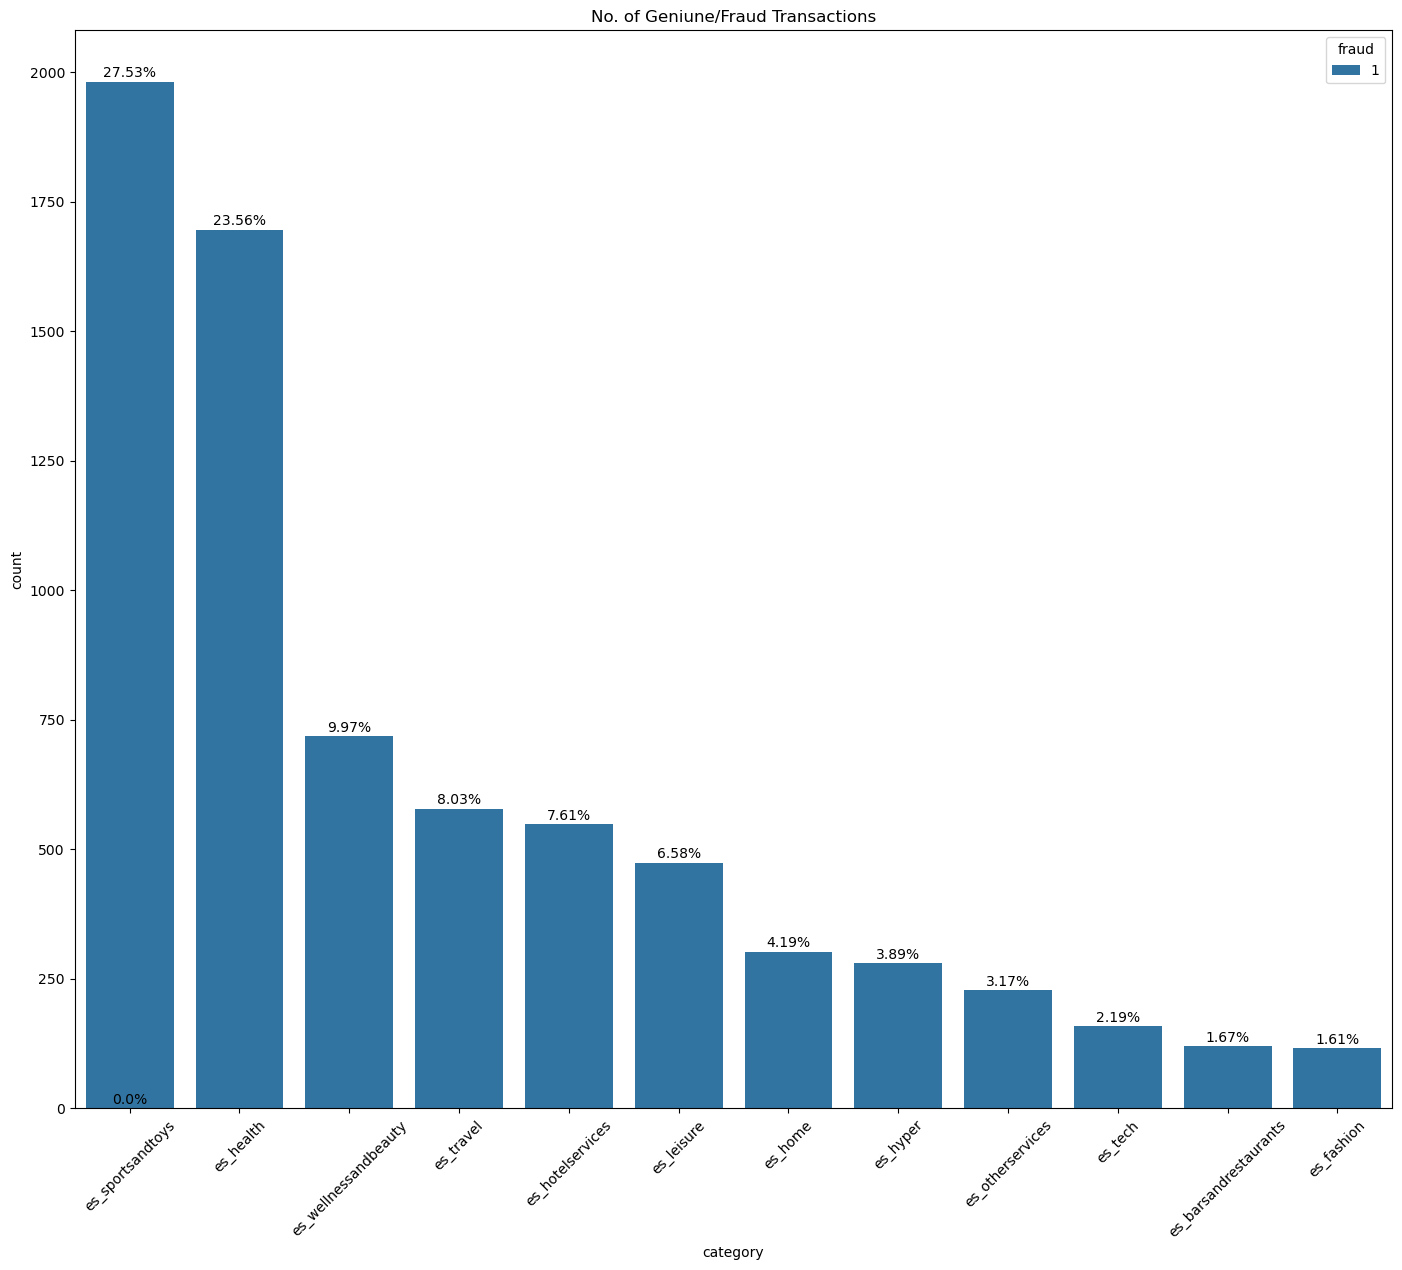

In [63]:
edaplot(df_fraud, 'category', title = 'No. of Geniune/Fraud Transactions', hue = 'fraud', legend=True)

In [64]:
#Over 40% of the total fraud transaction are es_sportsandtoys and es_health
df.groupby('category')['fraud'].mean()


category
es_barsandrestaurants    0.018829
es_contents              0.000000
es_fashion               0.017973
es_food                  0.000000
es_health                0.105126
es_home                  0.152064
es_hotelservices         0.314220
es_hyper                 0.045917
es_leisure               0.949900
es_otherservices         0.250000
es_sportsandtoys         0.495252
es_tech                  0.066667
es_transportation        0.000000
es_travel                0.793956
es_wellnessandbeauty     0.047594
Name: fraud, dtype: float64

C:\Users\tejas\AppData\Local\Temp\ipykernel_3260\894592821.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


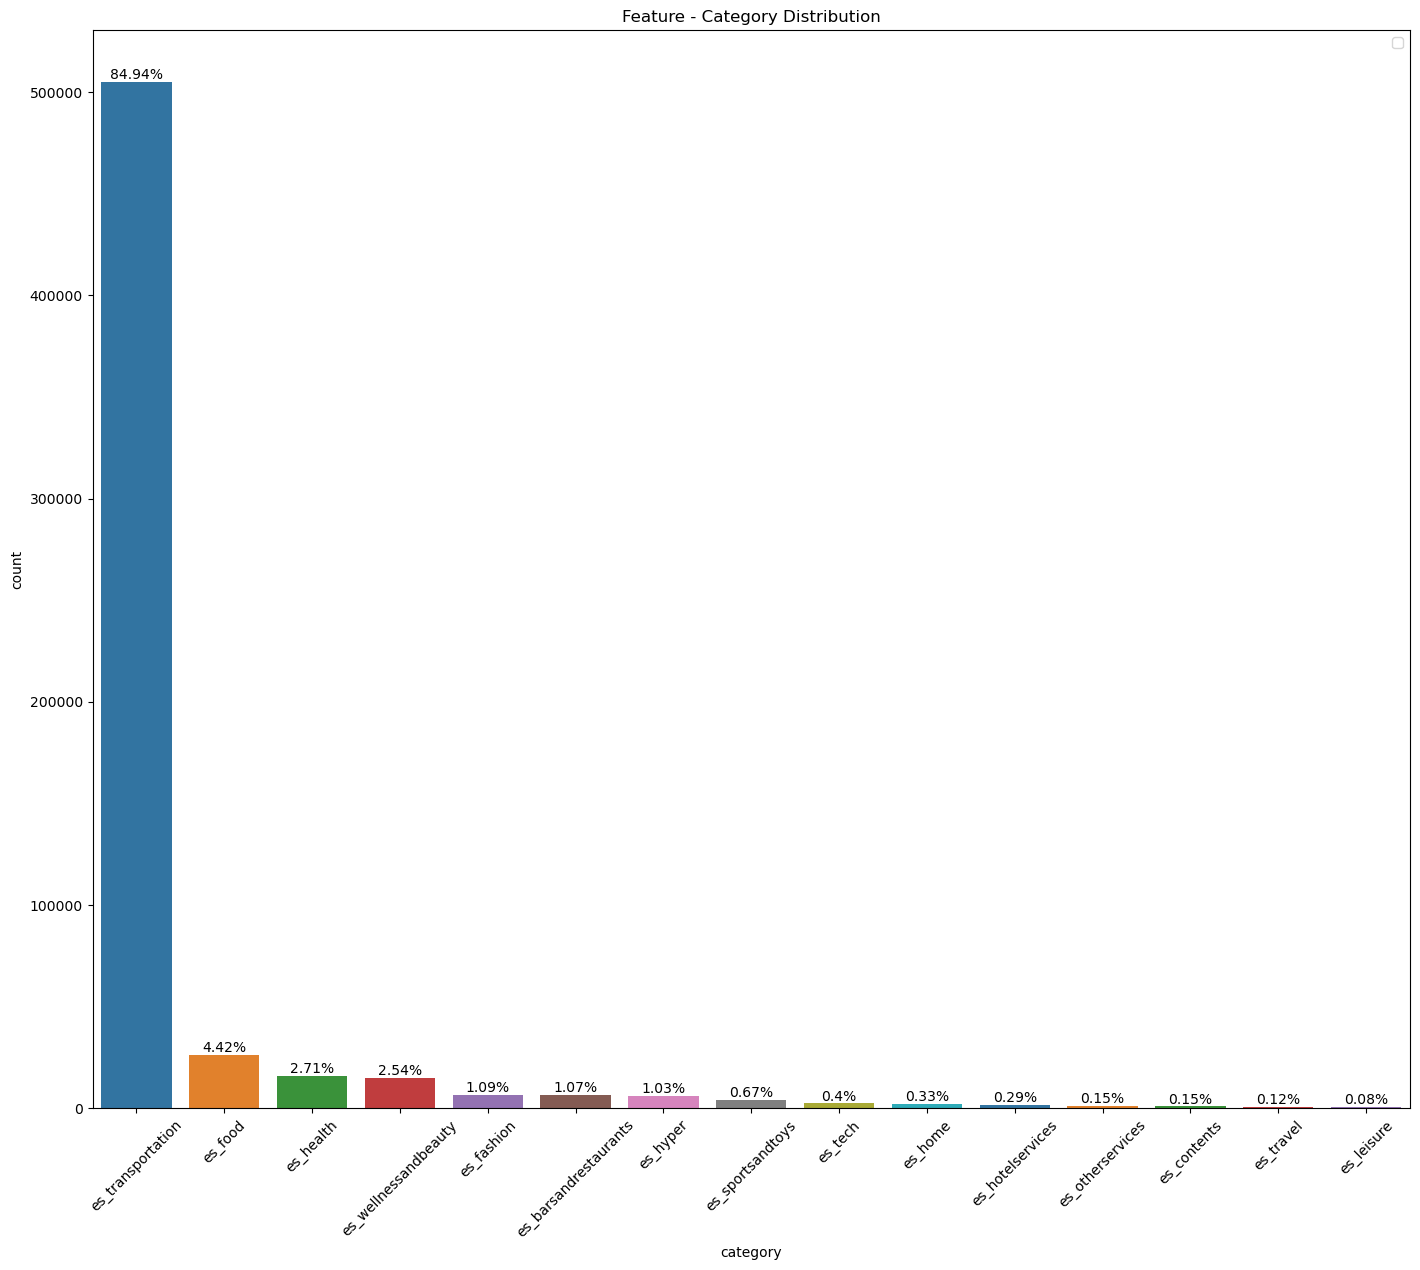

In [65]:
edaplot(df, 'category', title = 'Feature - Category Distribution')

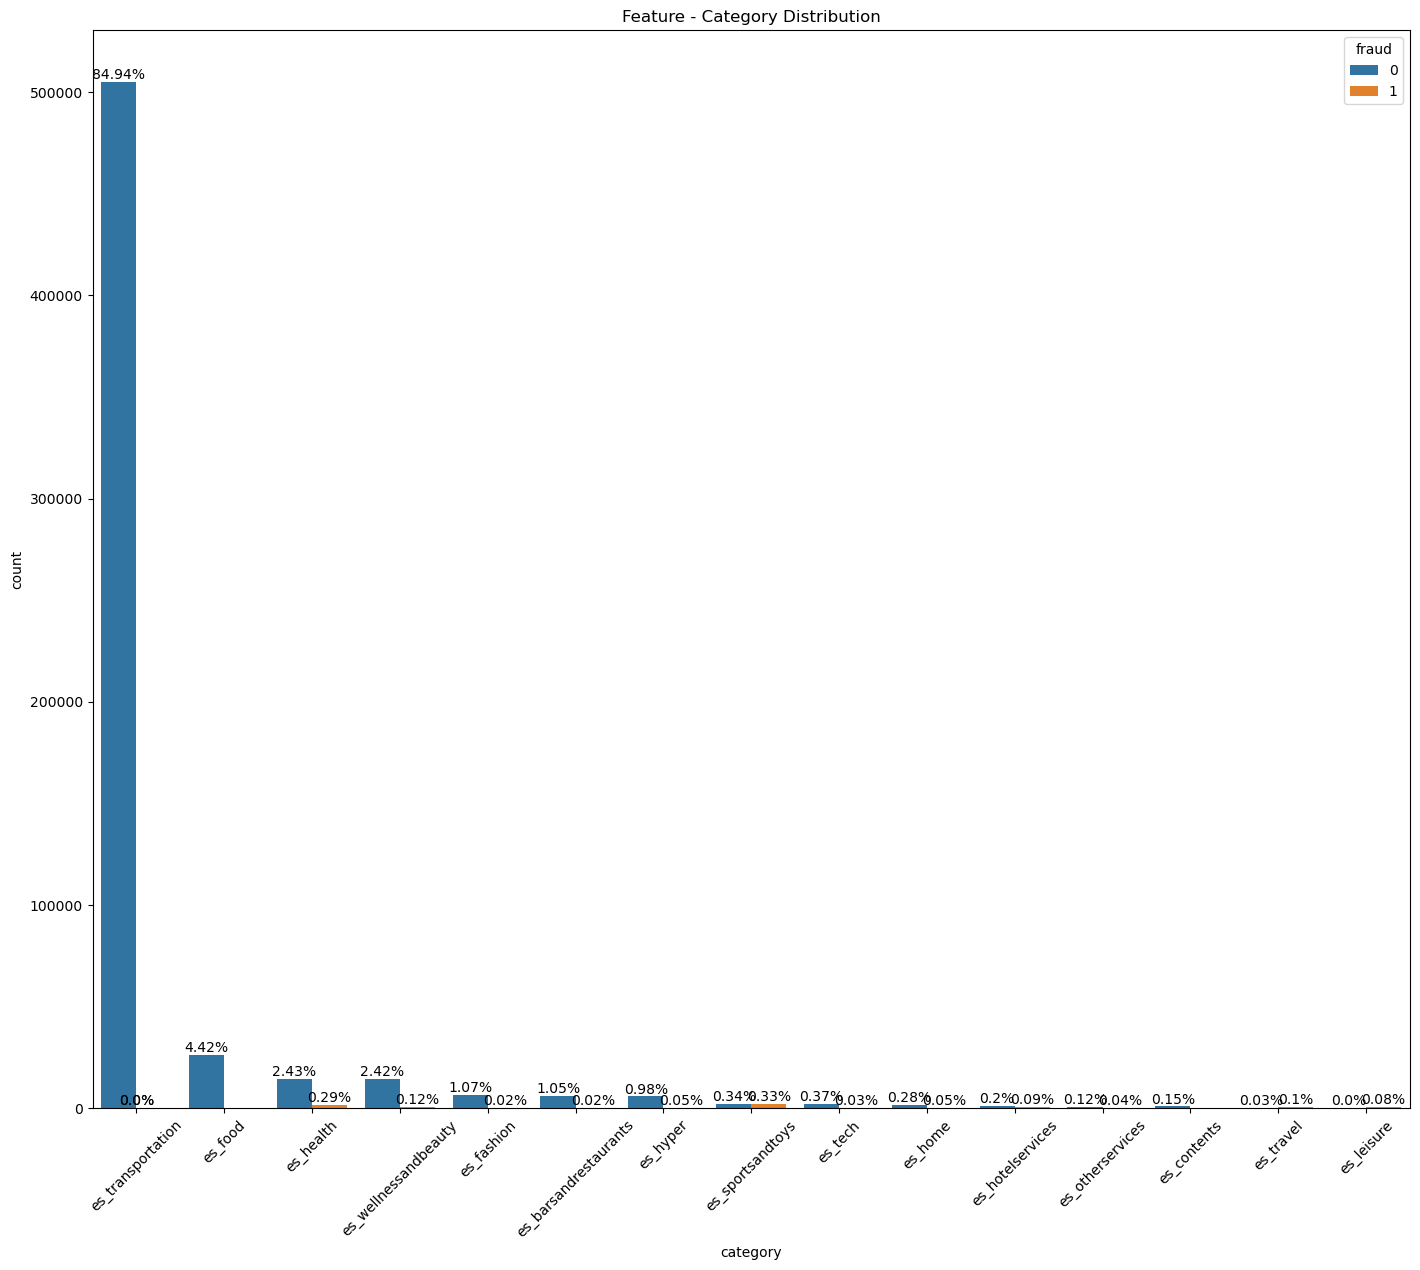

In [66]:
edaplot(df, 'category', title = 'Feature - Category Distribution', hue = 'fraud')

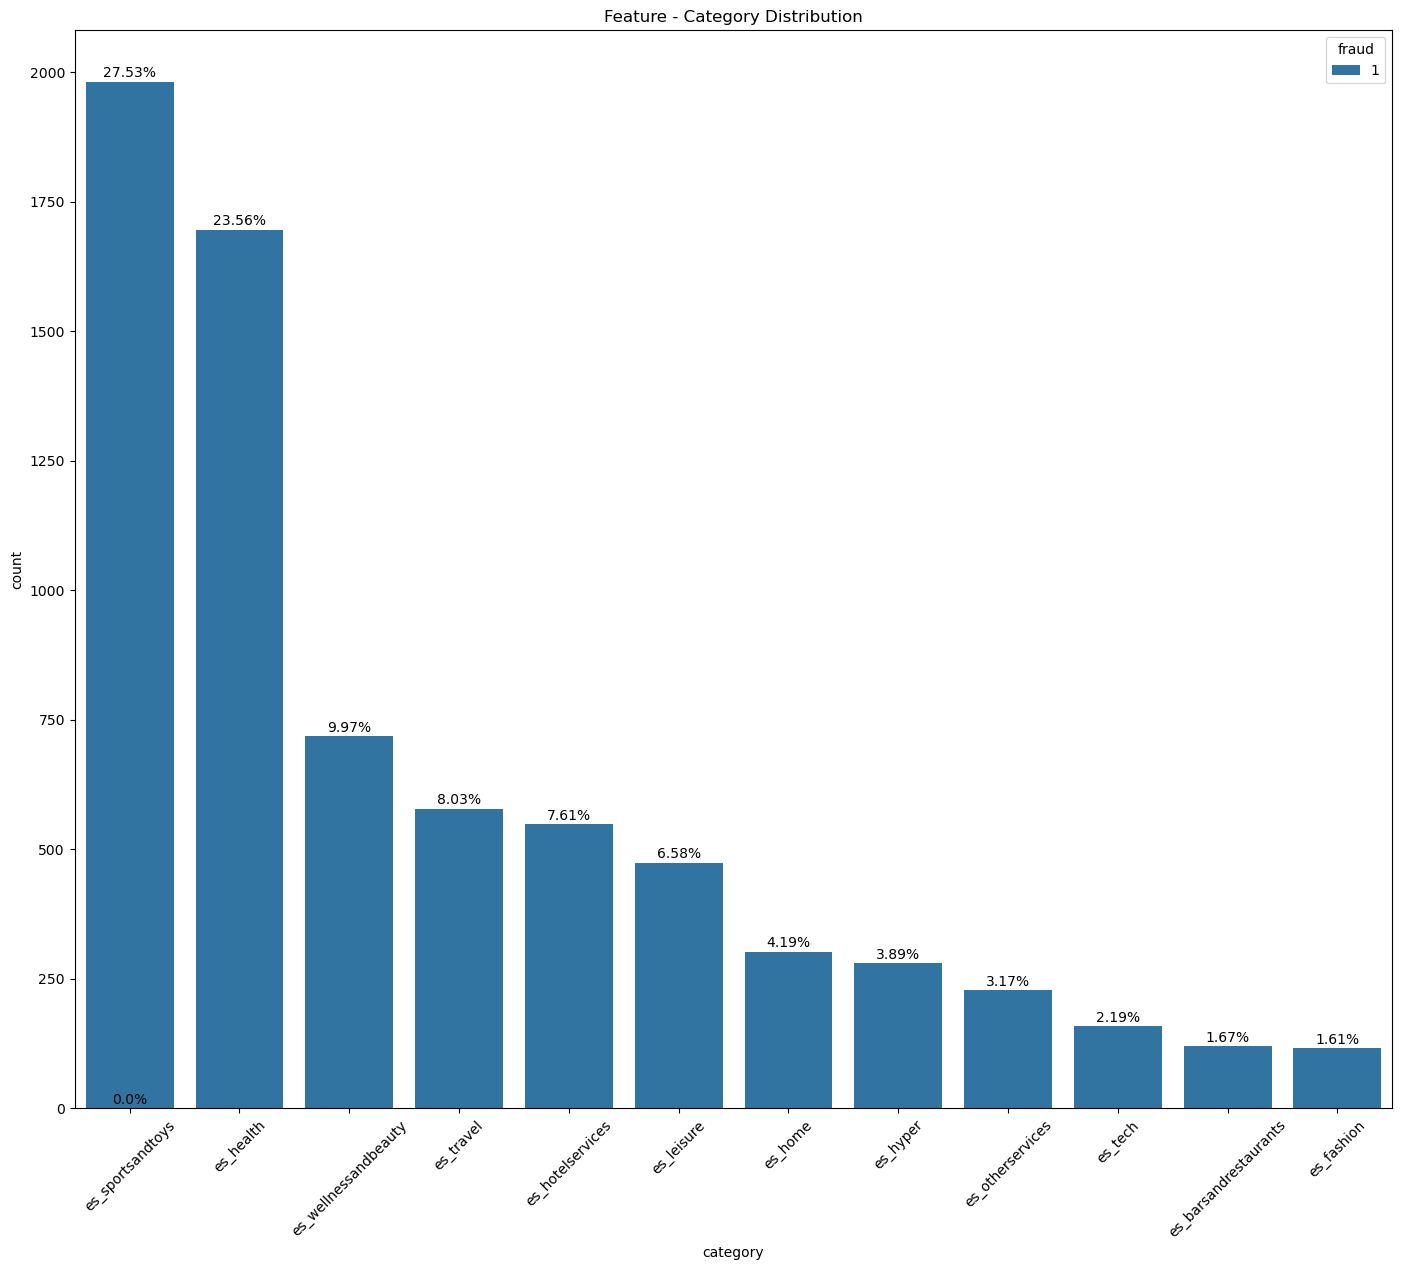

In [67]:
edaplot(df_fraud, 'category', title = 'Feature - Category Distribution', hue = 'fraud')

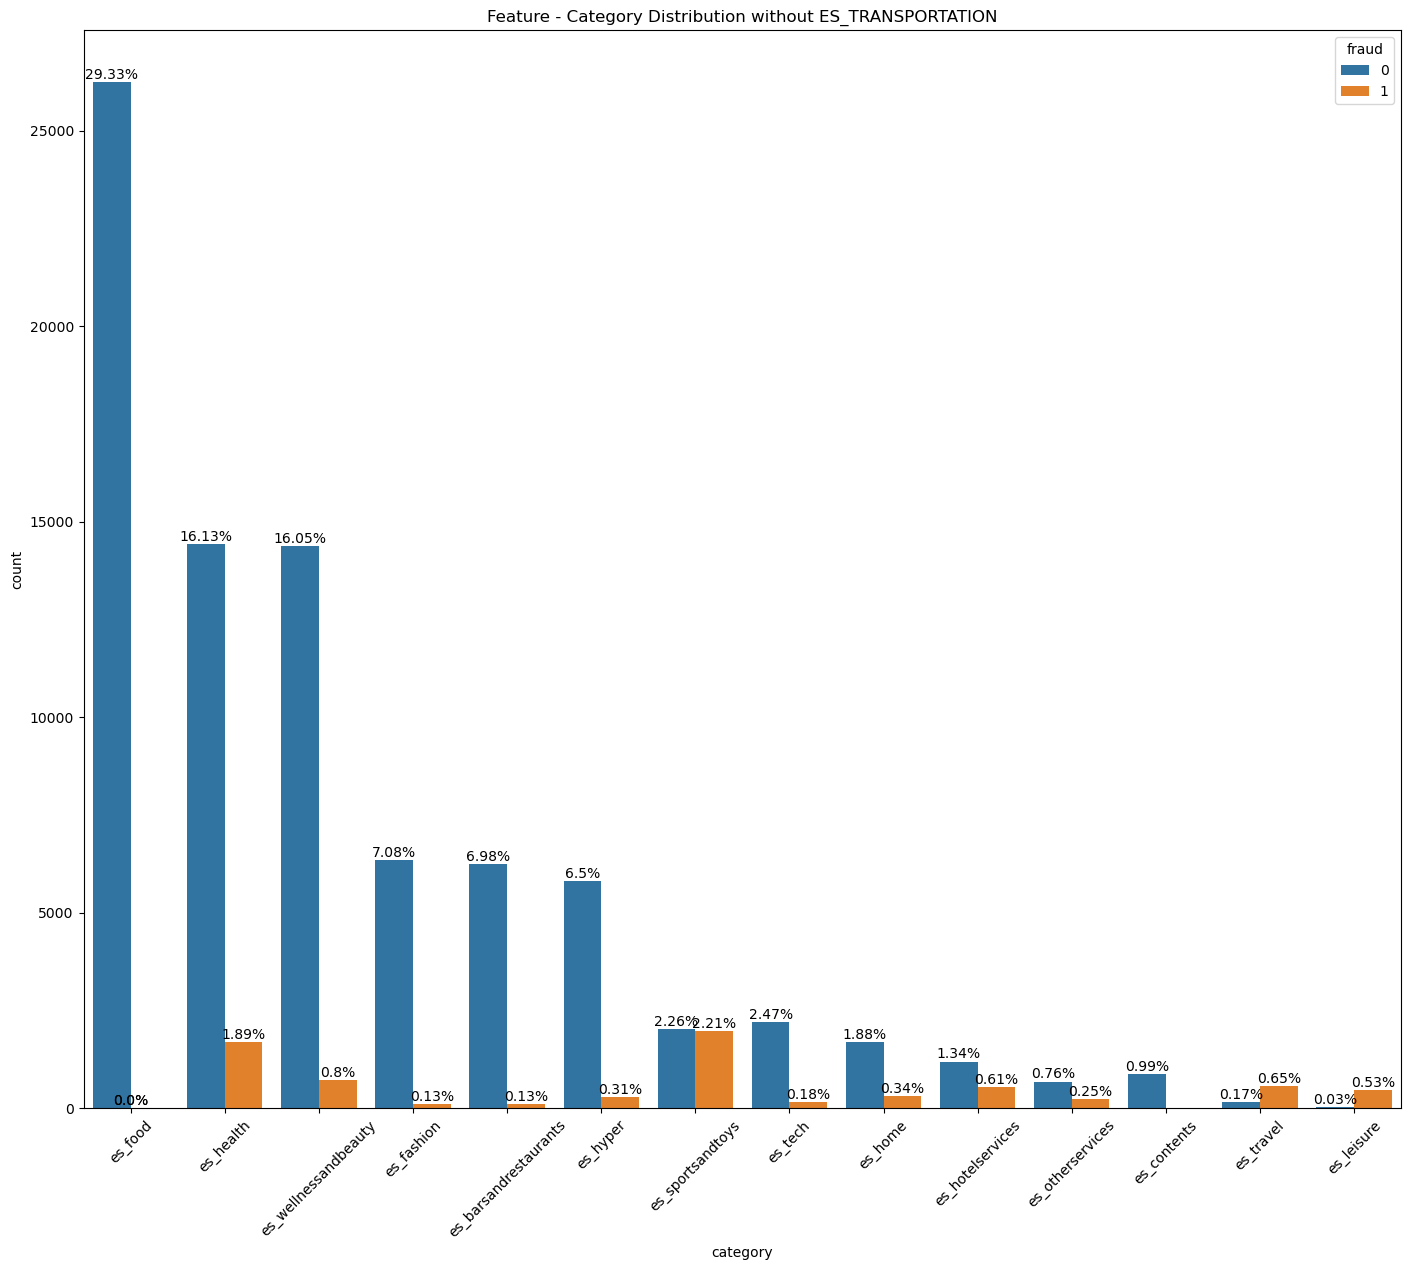

In [68]:
temp = df[df['category'] != 'es_transportation']
edaplot(temp, 'category', title = 'Feature - Category Distribution without ES_TRANSPORTATION', hue = 'fraud')

In [69]:
print('Fraudulent Transaction:')
print(f"Maximun amount of transaction: {df[df['fraud'] == 1]['amount'].max()}")
print(f"Minimum amount of transaction: {df[df['fraud'] == 1]['amount'].min()}")
print(f"Amount amount of transaction: {df[df['fraud'] == 1]['amount'].mean()}")

print('\nNon-Fraudulent Transaction:')
print(f"Maximun amount of transaction: {df[df['fraud'] == 0]['amount'].max()}")
print(f"Minimum amount of transaction: {df[df['fraud'] == 0]['amount'].min()}")
print(f"Amount amount of transaction: {df[df['fraud'] == 0]['amount'].mean()}")

Fraudulent Transaction:
Maximun amount of transaction: 8329.96
Minimum amount of transaction: 0.03
Amount amount of transaction: 530.9265513888889

Non-Fraudulent Transaction:
Maximun amount of transaction: 2144.86
Minimum amount of transaction: 0.0
Amount amount of transaction: 31.847230386607713


In [70]:
new_df = df.copy()
#Frequency Encoding customer and merchant features
for col in ['customer', 'merchant']:
    print(f"Frequency Encoding: {col} - {df[col].nunique()}")
    freq = df[col].value_counts()
    df[col] = df[col].apply(lambda x: freq[x])

Frequency Encoding: customer - 4112
Frequency Encoding: merchant - 50


In [71]:
for col in ['age', 'gender', 'category']:
    print(f"Unique values in '{col}':")
    print(df[col].unique())
    print("-" * 40)


Unique values in 'age':
['4' '2' '3' '5' '1' '6' 'U' '0']
----------------------------------------
Unique values in 'gender':
['M' 'F' 'E' 'U']
----------------------------------------
Unique values in 'category':
['es_transportation' 'es_health' 'es_otherservices' 'es_food'
 'es_hotelservices' 'es_barsandrestaurants' 'es_tech' 'es_sportsandtoys'
 'es_wellnessandbeauty' 'es_hyper' 'es_fashion' 'es_home' 'es_contents'
 'es_travel' 'es_leisure']
----------------------------------------


In [72]:

# Store mappings
label_mappings = {}

for col in ['age', 'gender', 'category']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    
    # Create and store mapping
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    label_mappings[col] = mapping
    
    print(f"Mapping for '{col}': {mapping}")
    print("-" * 40)


Mapping for 'age': {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, 'U': 7}
----------------------------------------
Mapping for 'gender': {'E': 0, 'F': 1, 'M': 2, 'U': 3}
----------------------------------------
Mapping for 'category': {'es_barsandrestaurants': 0, 'es_contents': 1, 'es_fashion': 2, 'es_food': 3, 'es_health': 4, 'es_home': 5, 'es_hotelservices': 6, 'es_hyper': 7, 'es_leisure': 8, 'es_otherservices': 9, 'es_sportsandtoys': 10, 'es_tech': 11, 'es_transportation': 12, 'es_travel': 13, 'es_wellnessandbeauty': 14}
----------------------------------------


In [73]:
df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,167,4,2,205426,12,4.55,0
1,0,169,2,2,205426,12,39.68,0
2,0,65,4,1,299693,12,26.89,0
3,0,171,3,2,205426,12,17.25,0
4,0,145,5,2,205426,12,35.72,0


In [74]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

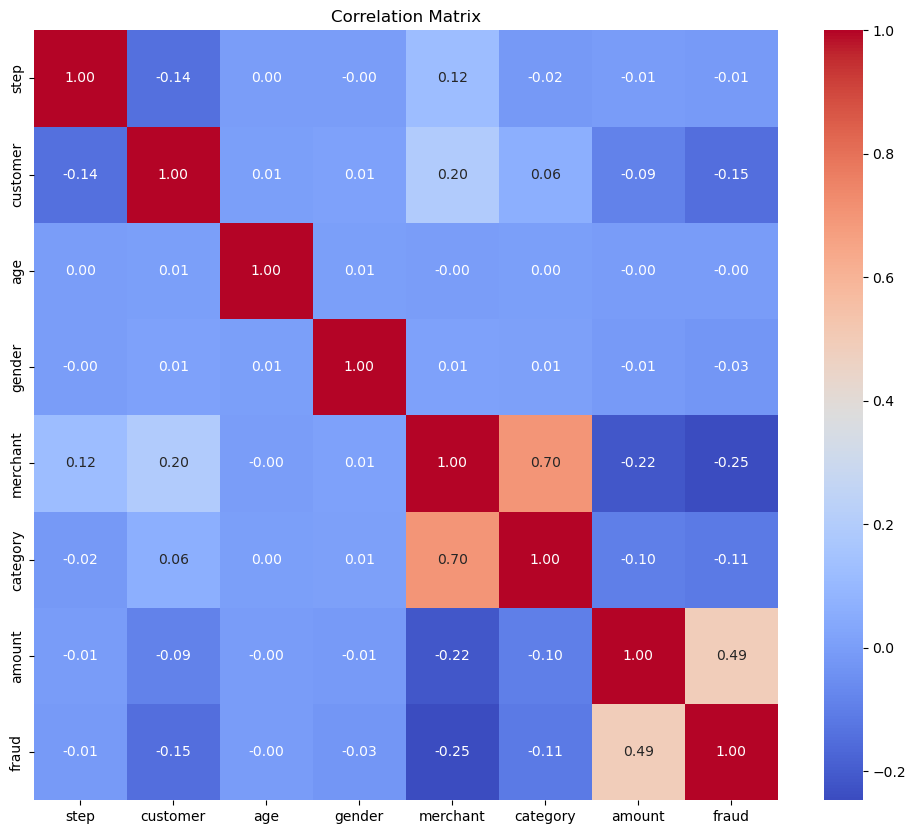

In [76]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [77]:
X = df.drop(['fraud'], axis = 1)
y = df['fraud']
print(X.head())
print("\n\n", y.head())

   step  customer  age  gender  merchant  category  amount
0     0       167    4       2    205426        12    4.55
1     0       169    2       2    205426        12   39.68
2     0        65    4       1    299693        12   26.89
3     0       171    3       2    205426        12   17.25
4     0       145    5       2    205426        12   35.72


 0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [78]:
scaler_pca = StandardScaler()
scaled_pca_df = scaler_pca.fit_transform(df)

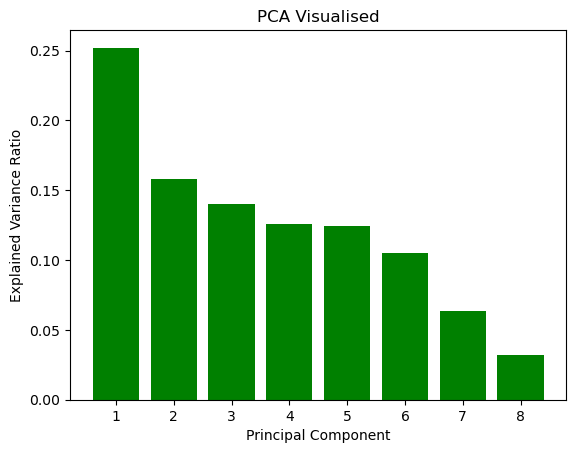

In [83]:
pca = PCA(n_components = 8) # Creating a PCA model using total variables (explanatory or not).
pca.fit(scaled_pca_df) # Fit the data...

# Let's plot the explained_variance_ratio_ in a similar manner to the lecture slides...
plt.bar(range(1,9), pca.explained_variance_ratio_, color='green') # Plot on the line graphs...
plt.title("PCA Visualised") # Show the title
plt.xlabel('Principal Component') # Show the x axis label
plt.ylabel('Explained Variance Ratio') # Show the y axis label
plt.xticks([1, 2, 3, 4, 5,6,7,8]) # Set the x axis range and values
plt.show() # Show the graph.

In [84]:
print(pca.explained_variance_ratio_) # Inspect the properties of explained_variance_ratio_

[0.25208542 0.15778136 0.13992907 0.12550146 0.12431942 0.10475934
 0.06324677 0.03237718]


In [85]:
from sklearn.utils.class_weight import compute_class_weight

y_copy = y.copy()
# Computing class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

# Creating a dictionary to map class labels to their computed weights
class_weight_dict = dict(zip(np.unique(y), class_weights))

class_weight_dict

{0: 0.5061282541455085, 1: 41.29465277777778}

In [86]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
#The splitting of the data is done before the SMOTE because we don't want the model that performs very well on the oversampled (and so somewhat artificial) dataset but falls short in a real-world setting where the class imbalance persists. This can result from oversampling the data before separating it. Enhancing the model's capacity to recognize the minority class is the aim of utilizing SMOTE; nevertheless, this should be verified on a test set that accurately reflects the real-world scenario.


In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve and AUC
    try:
        y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()
    except AttributeError:
        print(f"{model_name} does not support predict_proba, ROC curve cannot be plotted.")

    # Precision-Recall Curve and AUC
    try:
        precision, recall, thresholds_pr = precision_recall_curve(y_test, y_scores)
        pr_auc = auc(recall, precision)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='green', label=f'PR Curve (area = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {model_name}')
        plt.legend(loc='best')
        plt.show()
    except AttributeError:
        print(f"{model_name} does not support predict_proba, PR curve cannot be plotted.")


In [88]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

Classification Report for Random Forest Classifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193918
           1       0.91      0.79      0.85      2315

    accuracy                           1.00    196233
   macro avg       0.95      0.90      0.92    196233
weighted avg       1.00      1.00      1.00    196233



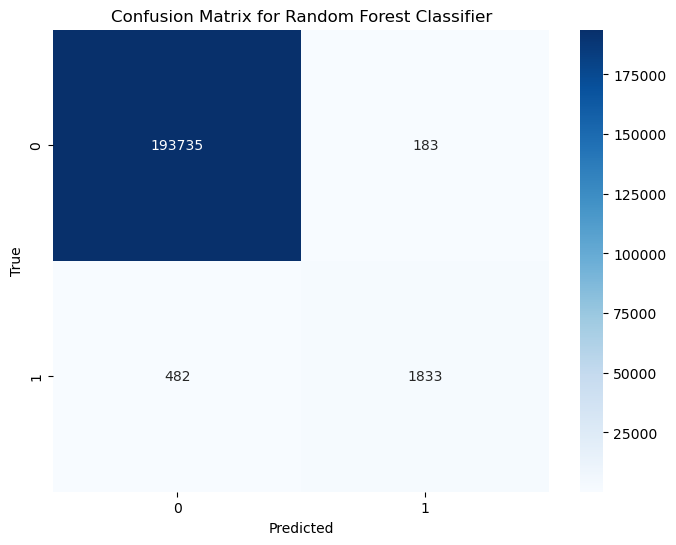

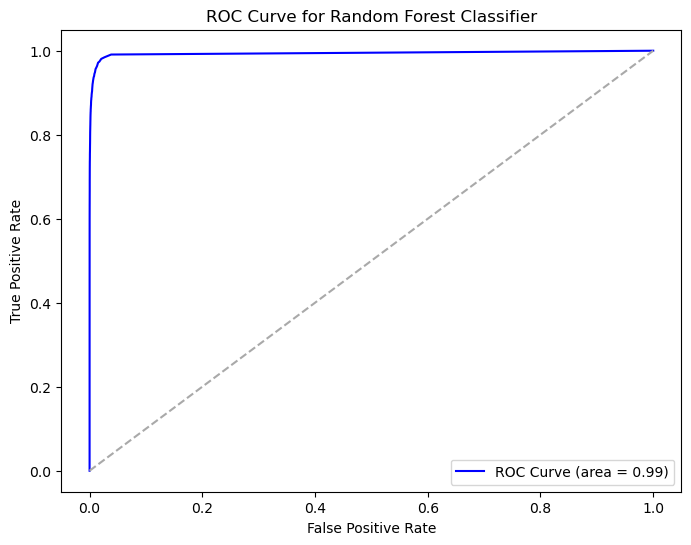

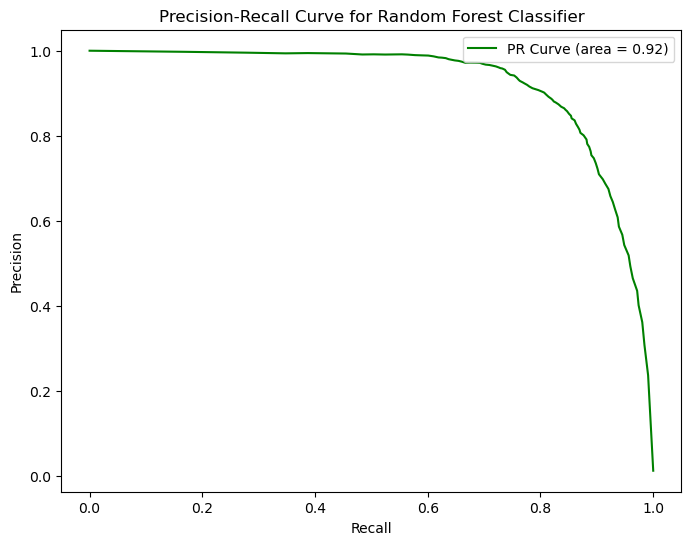

In [89]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the RandomForestClassifier model
random_forest_model = RandomForestClassifier()

# Evaluate the model
evaluate_model(random_forest_model, "Random Forest Classifier", X_train, y_train, X_test, y_test)

In [90]:
import warnings
# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

Classification Report for Balanced Random Forest Classifier:

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    193918
           1       0.24      0.99      0.39      2315

    accuracy                           0.96    196233
   macro avg       0.62      0.98      0.68    196233
weighted avg       0.99      0.96      0.97    196233



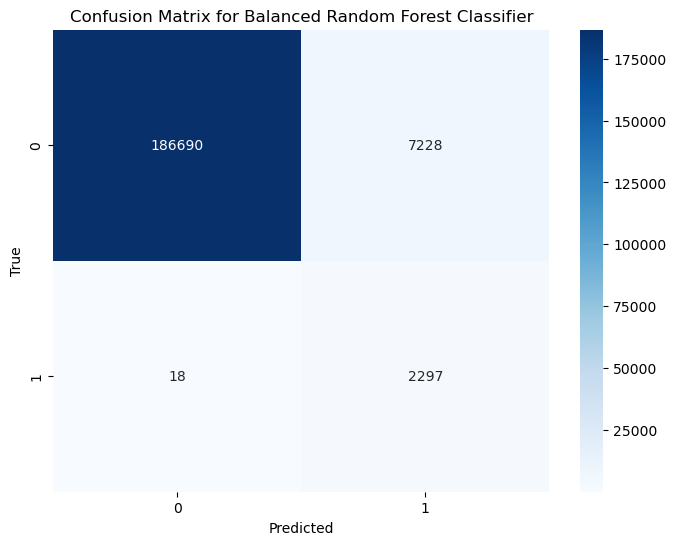

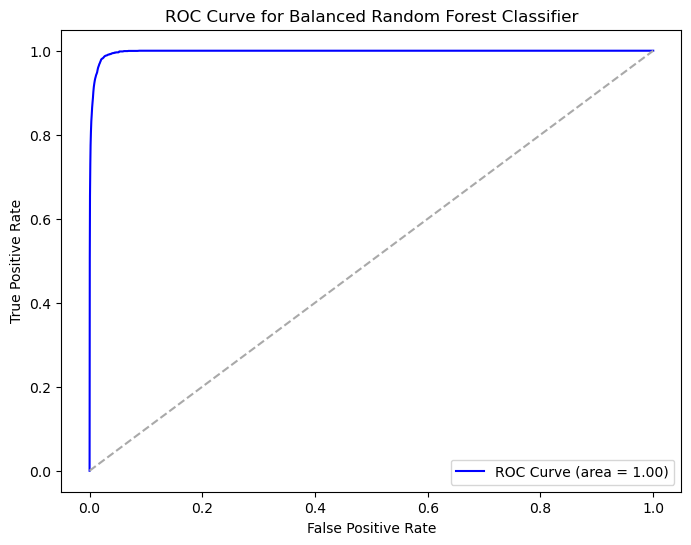

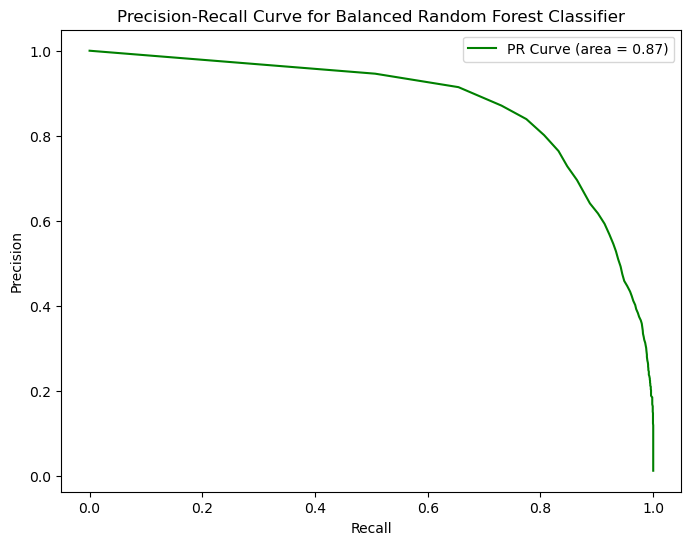

In [91]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Instantiate the BRF Classifier model
brf_classifier = BalancedRandomForestClassifier(n_estimators=100, random_state=42)

evaluate_model(brf_classifier, "Balanced Random Forest Classifier", X_train, y_train, X_test, y_test)

Classification Report for XGBoost Classifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193918
           1       0.88      0.79      0.83      2315

    accuracy                           1.00    196233
   macro avg       0.94      0.89      0.92    196233
weighted avg       1.00      1.00      1.00    196233



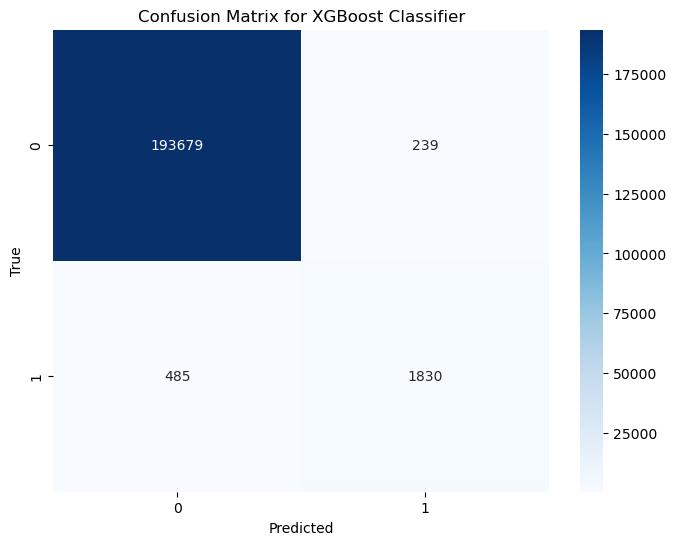

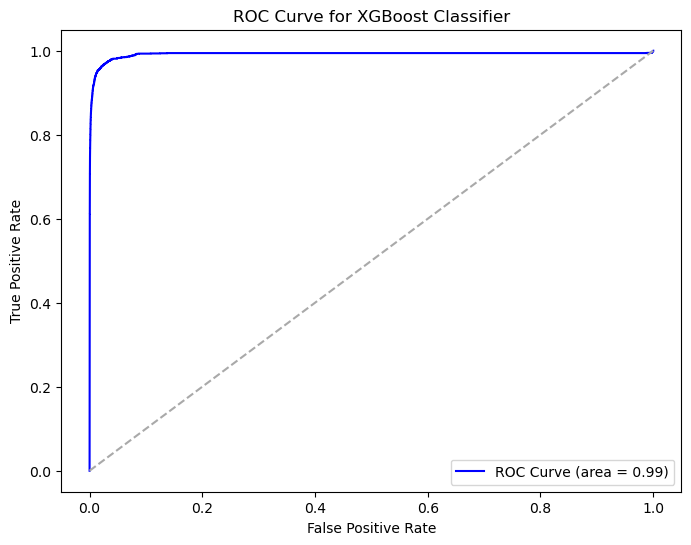

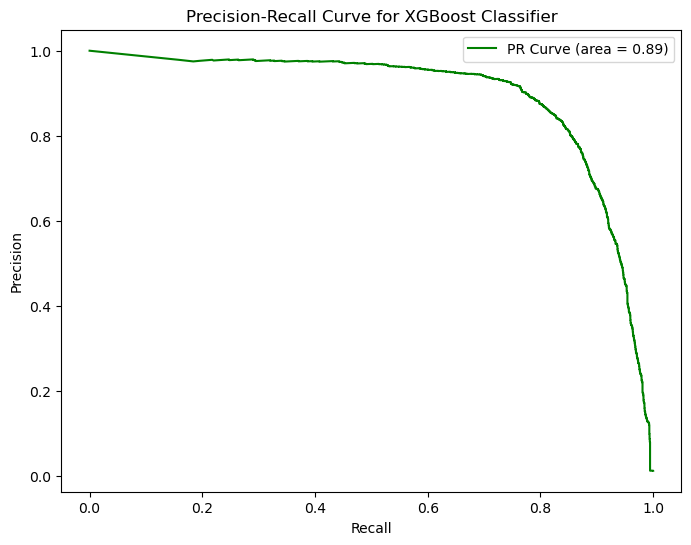

In [92]:
from xgboost import XGBClassifier

# Instantiate the XGBClassifier model
xgb_classifier_model = XGBClassifier()

# Evaluate the model
evaluate_model(xgb_classifier_model, "XGBoost Classifier", X_train, y_train, X_test, y_test)

Classification Report for AdaBoost:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193918
           1       0.90      0.70      0.79      2315

    accuracy                           1.00    196233
   macro avg       0.95      0.85      0.89    196233
weighted avg       1.00      1.00      1.00    196233



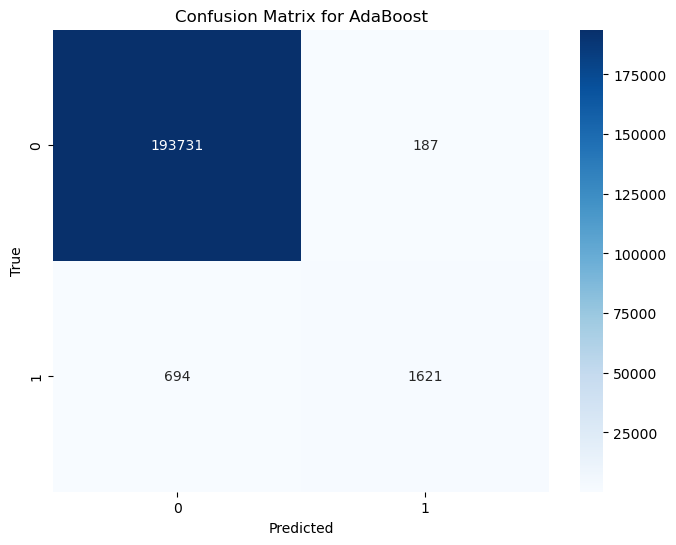

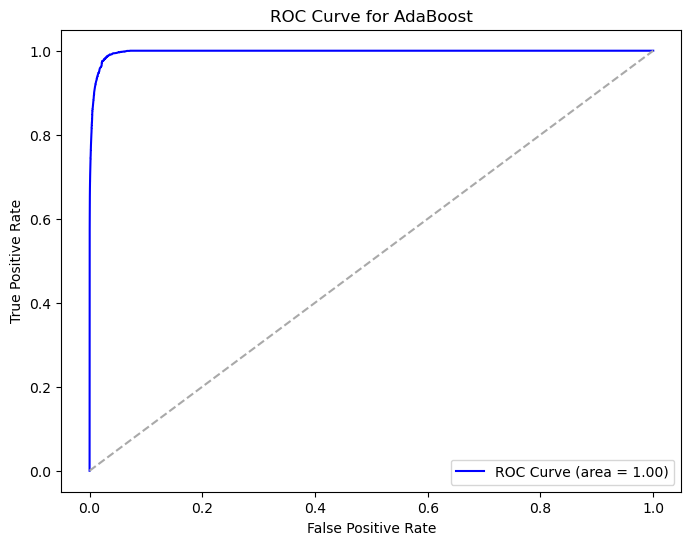

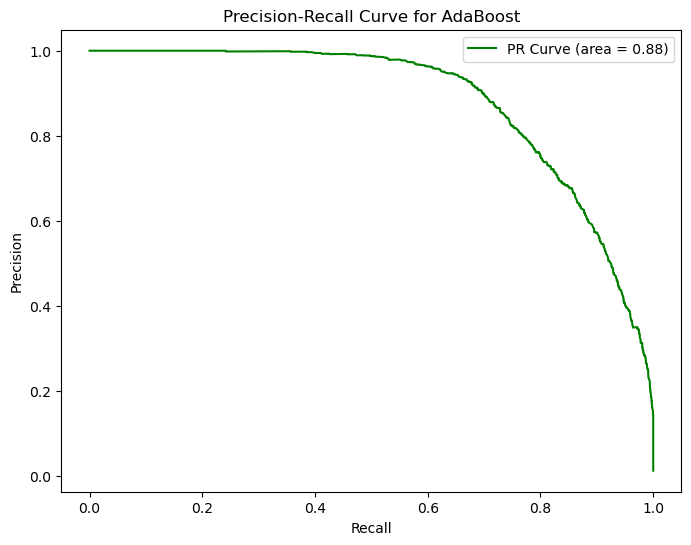

In [93]:
from sklearn.ensemble import AdaBoostClassifier

# Instantiate the LinearSVC model
ada = AdaBoostClassifier(random_state=42)

# Evaluate the model
evaluate_model(ada, "AdaBoost",  X_train, y_train, X_test, y_test)


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    193918
           1       0.16      0.99      0.27      2315

    accuracy                           0.94    196233
   macro avg       0.58      0.96      0.62    196233
weighted avg       0.99      0.94      0.96    196233



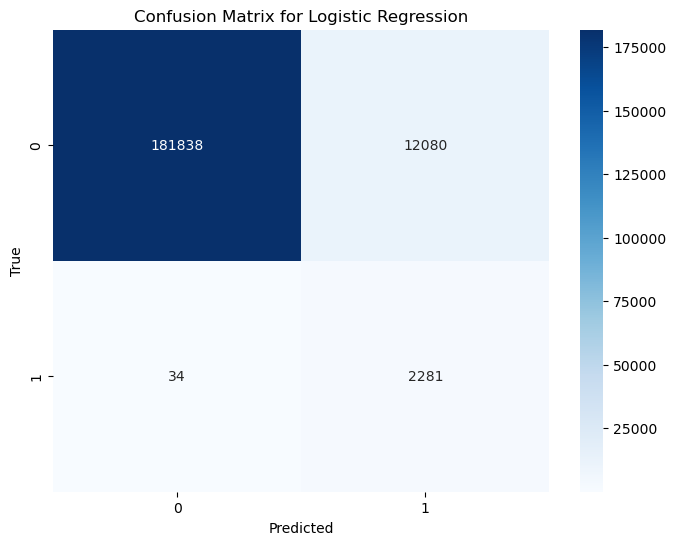

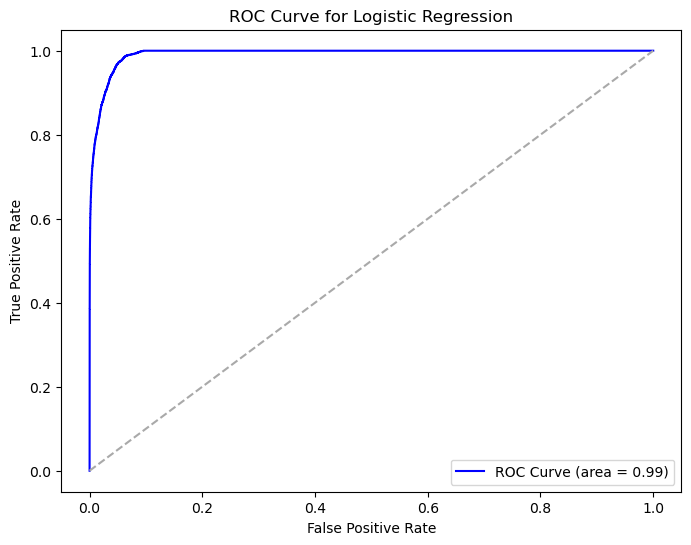

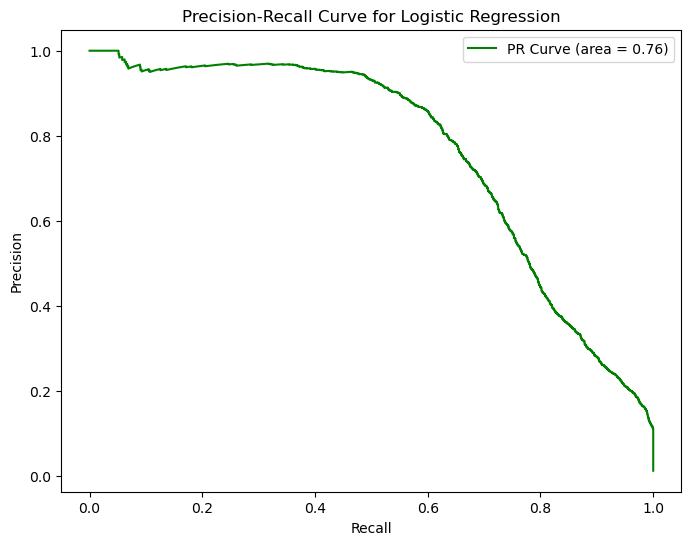

In [94]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
logistic_regression_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Evaluate the model
evaluate_model(logistic_regression_model, "Logistic Regression",  X_train, y_train, X_test, y_test)

# Results
### XGBoost and Random Forest show the most promising results for this classification problem.

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}
Classification Report for Best XGBoost:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193918
           1       0.90      0.82      0.86      2315

    accuracy                           1.00    196233
   macro avg       0.95      0.91      0.93    196233
weighted avg       1.00      1.00      1.00    196233



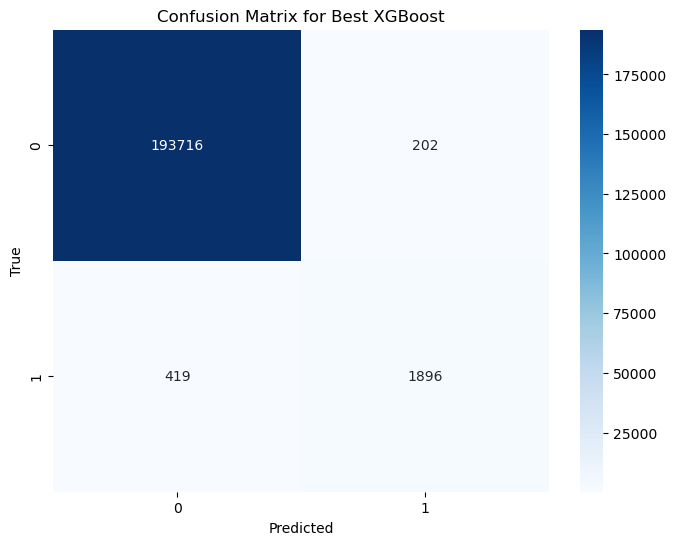

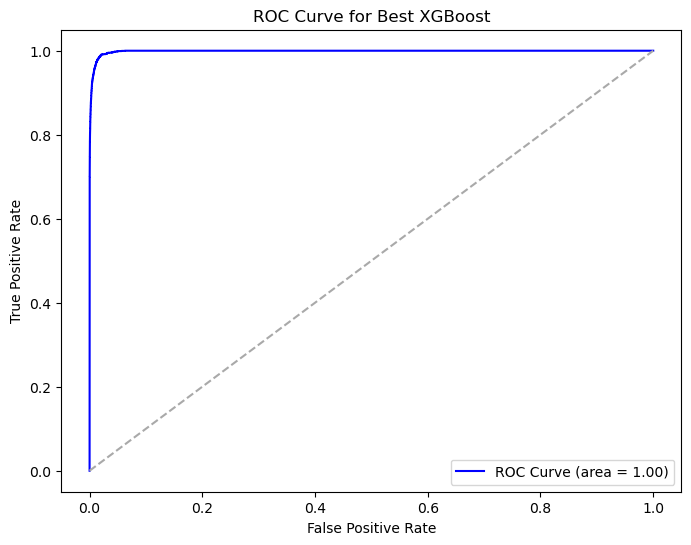

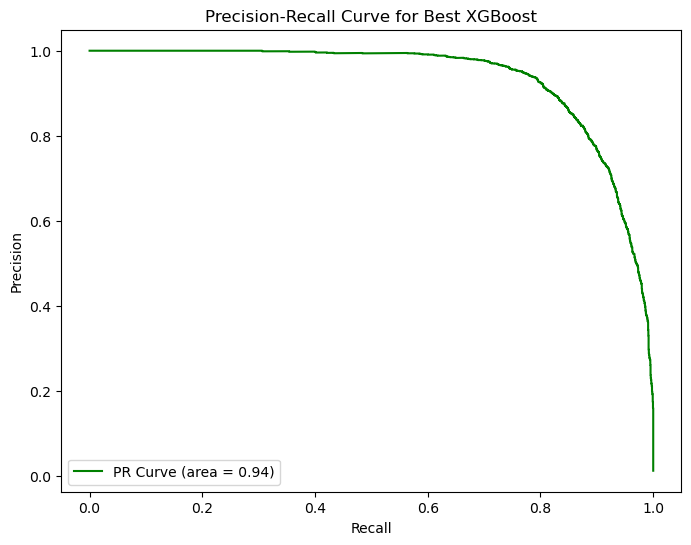

In [97]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Create a base model with the corrected objective parameter
xgb = XGBClassifier(random_state=42, objective='binary:logistic')

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           cv=cv, n_jobs=-1, verbose=1, scoring='recall')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model (optional)
best_model = grid_search.best_estimator_
evaluate_model(best_model, "Best XGBoost", X_train, y_train, X_test, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found:  {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 389}
Classification Report for Best RF:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193918
           1       0.93      0.78      0.85      2315

    accuracy                           1.00    196233
   macro avg       0.96      0.89      0.92    196233
weighted avg       1.00      1.00      1.00    196233



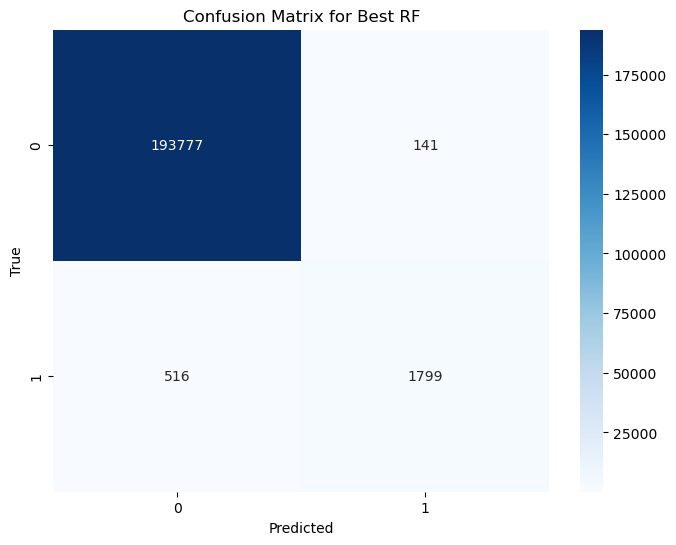

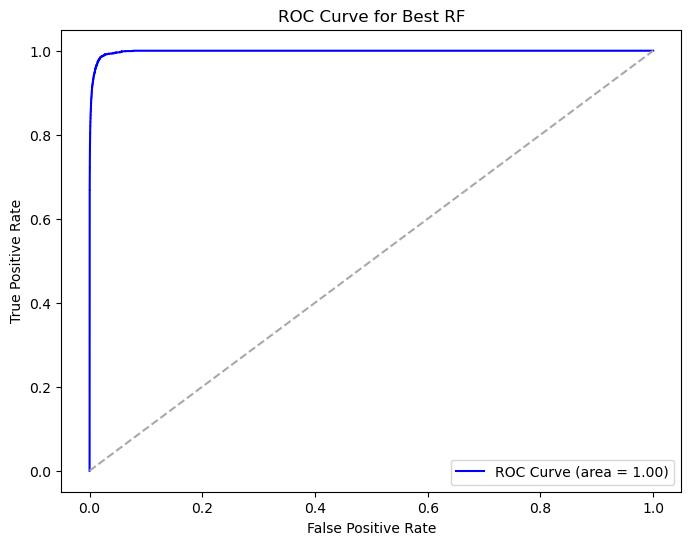

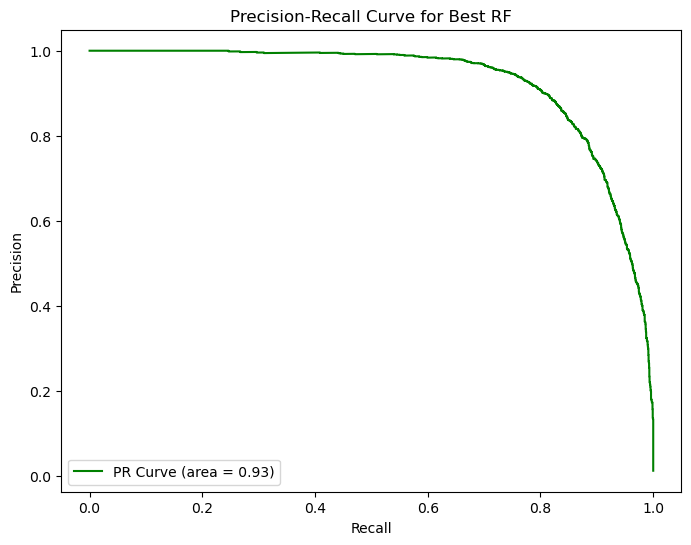

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

# Create a base Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the parameter distribution for Random Forest
param_dist = {
    'n_estimators': randint(100, 500),  # Random integers between 100 and 500
    'max_depth': randint(5, 15),        # Random integers between 5 and 15
    'min_samples_split': randint(2, 20),# Random integers between 2 and 20
    'min_samples_leaf': randint(1, 10)  # Random integers between 1 and 10
}

# Define StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Instantiate the random search model
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=100, cv=cv, n_jobs=-1, verbose=1, 
                                   random_state=42, scoring='recall')

# Fit the random search model to the data
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Evaluate the best model (assuming evaluate_model function is defined)
best_model = random_search.best_estimator_
evaluate_model(best_model, "Best RF", X_train, y_train, X_test, y_test)

Classification Report for Ensemble XGBoost + RF:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    193918
           1       0.94      0.76      0.84      2315

    accuracy                           1.00    196233
   macro avg       0.97      0.88      0.92    196233
weighted avg       1.00      1.00      1.00    196233



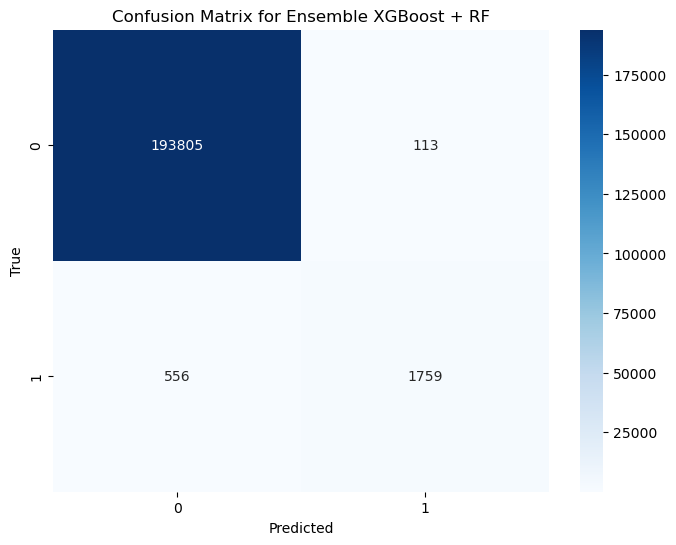

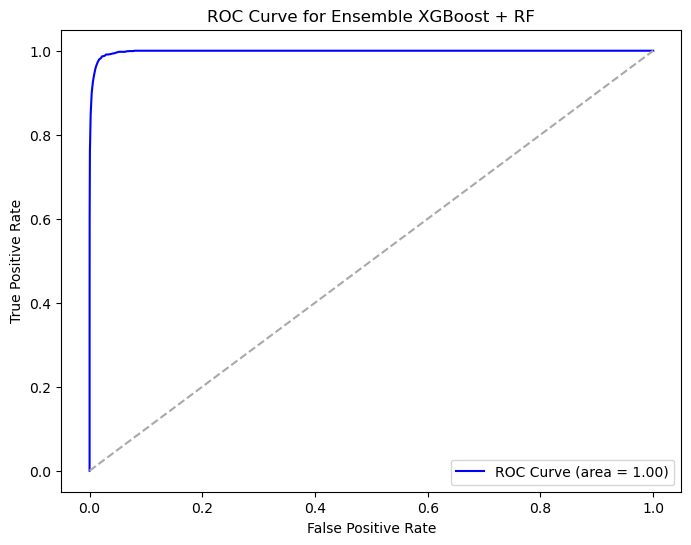

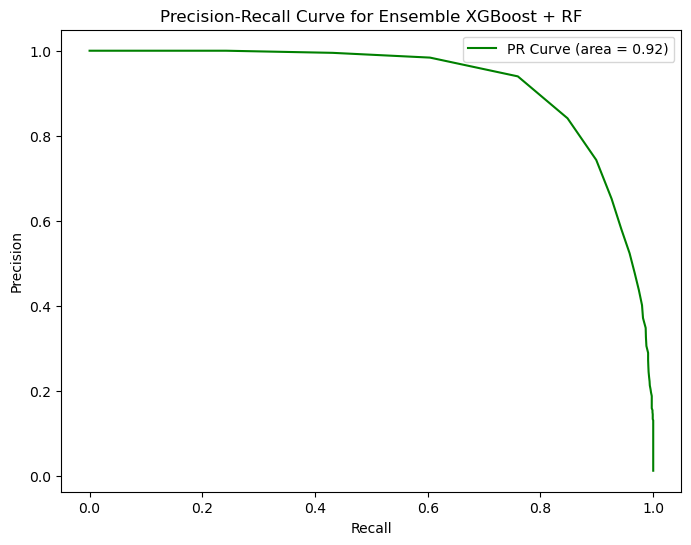

In [101]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Load the dataset
data = df.copy()

# Define the base model as Random Forest
base_model = RandomForestClassifier(random_state=42, max_depth= 14, min_samples_leaf = 1, min_samples_split= 16, n_estimators= 389)

# Define the meta-model as XGBoost
meta_model = XGBClassifier(use_label_encoder=False, eval_metric='aucpr', random_state=42, 
                           objective='binary:logistic',learning_rate = 0.1, max_depth= 5, n_estimators = 400, subsample = 0.8)

# Create the stacking model
stacked_model = StackingClassifier(estimators=[('rf', base_model)], final_estimator=meta_model)

# Train the stacked model
stacked_model.fit(X_train, y_train)

# Predict and evaluate the model
evaluate_model(stacked_model, "Ensemble XGBoost + RF", X_train, y_train, X_test, y_test)

In [102]:
import pickle

with open('banksim model.pkl', 'wb') as file:
    pickle.dump(stacked_model, file)

print("Model exported suucessfully!")


Model exported suucessfully!


In [ ]:
import numpy
import pandas
import matplotlib.pyplot
import seaborn
import gc
import sklearn
import warnings
import imblearn
import xgboost
import scipy

print("Library Versions:")
print(f"numpy: {numpy.__version__}")
print(f"pandas: {pandas.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"seaborn: {seaborn.__version__}")
print(f"scikit-learn: {sklearn.__version__}")
print(f"imblearn: {imblearn.__version__}")
print(f"xgboost: {xgboost.__version__}")
print(f"scipy: {scipy.__version__}")


Library Versions:
numpy: 1.26.4
pandas: 2.2.2
matplotlib: 3.8.4
seaborn: 0.13.2
scikit-learn: 1.4.2
imblearn: 0.12.3
xgboost: 3.0.0
scipy: 1.13.1


# Detecting Fraud in Banking Data – Summary

## 📊 Exploratory Data Analysis (EDA)

Initial EDA revealed the following insights:

1. **Class Imbalance**:  
   Only **1.21%** of the transactions were fraudulent, highlighting a strong class imbalance. This necessitates the use of:
   - Models robust to imbalanced data
   - Or synthetic data techniques (e.g., SMOTE, ADASYN)

2. **Fraudulent Transactions Involve Higher Amounts**:  
   Although frauds are fewer in number, they tend to involve **larger transaction amounts**.

3. **Risky Categories**:  
   Categories with the **most frequent frauds** include:
   - `es_sportsandtoys`
   - `es_health`
   - `es_wellnessandbeauty`

4. **Age Buckets**:  
   Fraud was most prevalent in age categories:
   - `2`
   - `3`

5. **Gender**:  
   Data indicated that **females were more involved** in fraud compared to males.

---

## 🧠 Dimensionality Reduction

Though dimensionality reduction was considered due to the high number of features, each component had a satisfactory level of **explained variance**. As a result, dimensionality reduction was **not pursued further**.

---

## 🎯 Classification Strategy & Metrics

In fraud detection:

- **Recall**: Measures how many actual frauds were correctly identified.  
  → Important for **catching all frauds**.

- **Precision**: Measures how many predicted frauds were truly fraudulent.  
  → Important for **avoiding unnecessary customer disruption**.

Hence, a balance between **Precision** and **Recall** is critical. Evaluation focused on:
- **Precision-Recall Curves (PR-AUC / AUC-PR)**
- **Type I & Type II Errors**

---

## 🏆 Model Evaluation

- **XGBoost with best parameters (via Grid Search)** was the top-performing model:
  - High **AUC**, **Precision**, and **Recall**
  - Lowest **Type II Error** (false negatives)

- While **Ensemble Learning** had the **lowest Type I Error** (false positives), the **priority is minimizing Type II Error** to avoid missing actual fraudulent transactions.

This aligns with the goal:  
> Predicting fraud in real-time with minimal missed frauds and reasonable accuracy.

